In [1]:
import warnings
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score
from sklearn.metrics import silhouette_score
import plotly.express as px
from geopy.distance import geodesic
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
import random

 Accessing the API to retrieve necessary data for evaluation.


In [2]:
url ='https://data.gov.il/api/3/action/datastore_search?resource_id=21fde05f-62e3-401b-81cf-5c385862026d&limit=4000'
req= requests.get(url)
data_api = req.json()

In [3]:
data=pd.DataFrame(data_api['result']['records'])
data

_id  Bank_Code                   Bank_Name  Branch_Code  Atm_Num  \
0        1         14         בנק אוצר החייל בע"מ          355     3551   
1        2         14         בנק אוצר החייל בע"מ          397     3976   
2        3         14         בנק אוצר החייל בע"מ          355     3552   
3        4         14         בנק אוצר החייל בע"מ          377     3773   
4        5         14         בנק אוצר החייל בע"מ          382     3821   
...    ...        ...                         ...          ...      ...   
3355  3356         52  בנק פועלי אגודת ישראל בע"מ          177     1772   
3356  3357         52  בנק פועלי אגודת ישראל בע"מ          177     1775   
3357  3358         26                  יובנק בע"מ          279     2791   
3358  3359         26                  יובנק בע"מ          288     2881   
3359  3360         26                  יובנק בע"מ          280     2801   

          ATM_Address     ATM_Address_Extra        City Commission  \
0     שד' מנחם בגין 7  מרכז צימר, ככר הסיטי       אשדוד         לא   
1        שד' דואני 18          שד' דואני 18        יבנה         לא   
2     שד' מנחם בגין 7  מרכז צימר, ככר הסיטי       אשדוד         לא   
3       שד' התמרים 11       שדרות התמרים 11        אילת         לא   
4           יוספטל 92           קניון בת ים       בת ים         לא   
...               ...                   ...         ...        ...   
3355           הר"ן 6     כיכר העיר בגבעה B  ביתר עילית         לא   
3356           הר"ן 6     כיכר העיר בגבעה B  ביתר עילית         לא   
3357         הרצל 182                            רחובות         לא   
3358     קרן היסוד 32                           ירושלים         לא   
3359        אחוזה 124     פינת רחוב בר אילן       רעננה         לא   

                      ATM_Type                     ATM_Location  \
0                  משיכת מזומן                     על קיר הסניף   
1     מכשיר מידע/או מתן הוראות  במרחק של יותר מ- 500 מטר מהסניף   
2                  משיכת מזומן                     על קיר הסניף   
3                  משיכת מזומן                       בתוך הסניף   
4                  משיכת מזומן                     על קיר הסניף   
...                        ...                              ...   
3355               משיכת מזומן                     על קיר הסניף   
3356  מכשיר מידע/או מתן הוראות                     על קיר הסניף   
3357               משיכת מזומן                     על קיר הסניף   
3358               משיכת מזומן                     על קיר הסניף   
3359               משיכת מזומן                     על קיר הסניף   

     Handicap_Access X_Coordinate Y_Coordinate  
0                 כן    31.788451    34.641896  
1                 כן    31.873128    34.738887  
2                 כן    31.788451    34.641896  
3                 כן    29.555192    34.952591  
4                 כן    32.015182    34.756167  
...              ...          ...          ...  
3355              כן    31.704657    35.116998  
3356              כן    31.704657    35.116998  
3357              כן    31.896860    34.811048  
3358              כן    31.772074    35.221880  
3359              לא    32.180927    34.873921  

[3360 rows x 14 columns]

In [4]:
#We noticed that some rows were written in the wrong columns. Since there were only a few of them, we decided to remove them as we have plenty of data.
data = data[(data['Handicap_Access'] == 'כן') | (data['Handicap_Access'] == 'לא')]


### Interactive map that shows the distribution of Handicap Accessibility 

In [5]:
fig = px.scatter_mapbox(data,lat="X_Coordinate",lon="Y_Coordinate",color="Handicap_Access",  color_discrete_map={'כן': 'green', 'לא': 'red'}, zoom=7,center={"lat":31.89, "lon": 35},title="ATM Accessibility Map",)

fig.update_layout(mapbox_style="open-street-map",width=1200,  height=800,legend_title=dict(text="Accessibility"))

fig.show()

## Preprocessing

In [6]:
X=data.drop(columns=['Handicap_Access'])
y=data['Handicap_Access']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#removing feature that are not helpful to our opinion
X_train = X_train.drop(columns=['ATM_Address_Extra', '_id', 'Bank_Name', 'Atm_Num'])
X_test = X_test.drop(columns=['ATM_Address_Extra', '_id', 'Bank_Name', 'Atm_Num'])

In [9]:
#removing blank/Nan values and taking care of features type 
X_train = X_train.drop(X_train[X_train['X_Coordinate'] == ''].index)
X_test = X_test.drop(X_test[X_test['X_Coordinate'] == ''].index)

X_train['X_Coordinate'] = X_train['X_Coordinate'].astype('float64')
X_train['Y_Coordinate'] = X_train['Y_Coordinate'].astype('float64')

X_test['X_Coordinate'] = X_test['X_Coordinate'].astype('float64')
X_test['Y_Coordinate'] = X_test['Y_Coordinate'].astype('float64')

In [10]:

X_train['ATM_Type'] = X_train['ATM_Type'].astype('category')
X_train['ATM_Location'] = X_train['ATM_Location'].astype('category')

X_test['ATM_Type'] = X_test['ATM_Type'].astype('category')
X_test['ATM_Location'] = X_test['ATM_Location'].astype('category')


y_train = y_train.astype('category')
y_test = y_test.astype('category')


In [11]:
#A few outliers intrupted our data duo to wrong typing so we decided to remove that as well

X_train = X_train[X_train['X_Coordinate'] < 90]
X_train = X_train[X_train['Y_Coordinate'] < 90]
y_train = y_train[X_train.index] 


X_test = X_test[X_test['X_Coordinate'] < 90]
X_test = X_test[X_test['Y_Coordinate'] < 90]
y_test = y_test[X_test.index] 


In [12]:
#Here we are mapping the yes and no handicap access feature
y_train = y_train.map({'כן': 1, 'לא': 0})
y_test = y_test.map({'כן': 1, 'לא': 0})


X_train['Commission'] = X_train['Commission'].map({'כן': 1, 'לא': 0})
X_test['Commission'] = X_test['Commission'].map({'כן': 1, 'לא': 0})


### ONE HOT Encoder

In [13]:
columns_to_encode = ['ATM_Address', 'City', 'ATM_Type', 'ATM_Location']


encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')


X_train_encoded = encoder.fit_transform(X_train[columns_to_encode])


X_test_encoded = encoder.transform(X_test[columns_to_encode])


X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(columns_to_encode))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(columns_to_encode))


X_train = X_train.drop(columns=columns_to_encode).reset_index(drop=True)
X_test = X_test.drop(columns=columns_to_encode).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

### Scaling

In [14]:
scaler = StandardScaler()


coordinates_train = X_train[['X_Coordinate', 'Y_Coordinate']]
coordinates_test = X_test[['X_Coordinate', 'Y_Coordinate']]


scaled_coordinates_train = scaler.fit_transform(coordinates_train)

scaled_coordinates_test = scaler.transform(coordinates_test)

X_train[['X_Coordinate', 'Y_Coordinate']] = scaled_coordinates_train
X_test[['X_Coordinate', 'Y_Coordinate']] = scaled_coordinates_test

#### Implementing the classification models and assessing their performance.

In [15]:
#We chose to predict whether there will be handicap accessibility based on the location, bank information, city, and ATM type. 
# Following this, we aim to cluster areas and recommend regions across the country where enforcement of handicap accessibility should be prioritized.

Logistic Regression 

here we preformed a grid search to find the optimal parameters for LR , it takes alot of running time so we are not going to run it everytime

In [16]:
def eval(model, X_train, X_test, y_train, y_test):
   
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    #chat-gpt  only wrote if and else statements in this function we did
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1] 
    else:
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - np.min(y_prob)) / (np.max(y_prob) - np.min(y_prob))  

    
    cv = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
    

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print(f"Cross-validation accuracy={cv} Accuracy mean= {float(np.mean(cv))}")
    print(f"F1 score = {f1}")
    print(f"AUC = {auc}")
    print(f"Recall = {recall}")
    print(f"Precision = {precision}")

In [17]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression

# # Define parameter grid
# param_grid_lr = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'lbfgs'],
#     'max_iter': [100, 200, 500],
# }

# # Perform Grid Search
# grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, scoring='accuracy', cv=5, verbose=1)
# grid_search_lr.fit(X_train, y_train)

# print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)


In [18]:
eval(LogisticRegression(C=1,penalty='l2',solver='lbfgs'),X_train,X_test,y_train,y_test)

Cross-validation accuracy=[0.94029851 0.94029851 0.94216418 0.94216418 0.94205607] Accuracy mean= 0.9413962895801367
F1 score = 0.9708141321044547
AUC = 0.6156564396773926
Recall = 0.9984202211690363
Precision = 0.9446935724962631


Random Forest 

In [19]:
eval(RandomForestClassifier(),X_train,X_test,y_train,y_test)

Cross-validation accuracy=[0.93843284 0.92723881 0.93097015 0.92537313 0.93271028] Accuracy mean= 0.9309450411493932
F1 score = 0.9619269619269619
AUC = 0.8051051800116404
Recall = 0.9778830963665087
Precision = 0.9464831804281345


Support Vector Machine

In [20]:
eval(SVC(),X_train,X_test,y_train,y_test)

Cross-validation accuracy=[0.94029851 0.94029851 0.94029851 0.94029851 0.94018692] Accuracy mean= 0.9402761891477194
F1 score = 0.9708588957055214
AUC = 0.554336077159724
Recall = 1.0
Precision = 0.9433681073025335


XGBoost

In [21]:
eval(XGBClassifier(),X_train,X_test,y_train,y_test) 

Cross-validation accuracy=[0.93843284 0.91791045 0.92723881 0.91791045 0.94205607] Accuracy mean= 0.9287097224159575
F1 score = 0.959937156323645
AUC = 0.847385050303484
Recall = 0.9652448657187994
Precision = 0.9546875


K-Nearest Neighbors

In [22]:
# from sklearn.model_selection import GridSearchCV

# from sklearn.neighbors import KNeighborsClassifier

# # Define parameter grid
# param_grid_knn = {
#     'n_neighbors': [3, 5, 10, 15],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan', 'minkowski'],
# }

# # Perform Grid Search
# grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring='accuracy', cv=5, verbose=1)
# grid_search_knn.fit(X_train, y_train)

# print("Best parameters for KNN:", grid_search_knn.best_params_)

In [23]:
eval(KNeighborsClassifier(metric='euclidean',n_neighbors=15,weights='uniform'),X_train,X_test,y_train,y_test)

Cross-validation accuracy=[0.94029851 0.94029851 0.94029851 0.94029851 0.94018692] Accuracy mean= 0.9402761891477194
F1 score = 0.9708588957055214
AUC = 0.741186497048308
Recall = 1.0
Precision = 0.9433681073025335


XGBoost preformed better in the AUC score so we decided to go with that model .

In [24]:
xgb = XGBClassifier().fit(X_train,y_train)
y_pred = xgb.predict(X_test)

# Clusters

### Preprocessing

In [25]:
data = data.drop(data[data['X_Coordinate']==''].index)
data['X_Coordinate'] = data['X_Coordinate'].astype('float64')
data['Y_Coordinate'] = data['Y_Coordinate'].astype('float64')
data = data[data['X_Coordinate'] < 90]
data = data[data['Y_Coordinate'] < 90]

In [26]:
#removing feature that are not helpful to our opinion
data = data.drop(columns=['ATM_Address_Extra', '_id', 'Bank_Name', 'Atm_Num'])
coordinates = data[['X_Coordinate', 'Y_Coordinate']].values

In [27]:
#We came across this function online to calculate distances between points on a map 
def calculate_distance(row1, row2):
    point1 = (row1['X_Coordinate'], row1['Y_Coordinate'])
    point2 = (row2['X_Coordinate'], row2['Y_Coordinate'])
    return geodesic(point1, point2).meters  

## DBSCAN

In [28]:
data_dbscan = data.copy()
dbscan = DBSCAN(eps=0.068, min_samples=3)  
data_dbscan['Cluster'] = dbscan.fit_predict(coordinates)

In [29]:
fig = px.scatter_mapbox(data_dbscan,lat="X_Coordinate",lon="Y_Coordinate",color="Cluster", hover_data=["X_Coordinate", "Y_Coordinate", "Cluster", "Handicap_Access"],  color_continuous_scale='Viridis',  zoom=7,center={"lat":31.89, "lon": 35},title="ATM Clusters Map")

fig.update_layout(mapbox_style="open-street-map", width=1200,height=800,legend_title=dict(text="Clusters"))

fig.show()

## KMeans

In [30]:
data_kmeans = data.copy()
kmeans = KMeans(n_clusters=5)
data_kmeans['Cluster'] = kmeans.fit_predict(coordinates)

In [31]:
fig = px.scatter_mapbox(data_kmeans,lat="X_Coordinate",lon="Y_Coordinate",color="Cluster",  hover_data=["X_Coordinate", "Y_Coordinate", "Cluster", "Handicap_Access"],  color_continuous_scale='Viridis',  zoom=7,center={"lat":31.89, "lon": 35},title="ATM Clusters Map")

fig.update_layout(mapbox_style="open-street-map",width=1200,height=800,legend_title=dict(text="Clusters"))

fig.show()

## Gaussian Mixture Models

In [32]:
data_gmm = data.copy()
gmm = GaussianMixture(n_components=6, random_state=42)
data_gmm['Cluster'] = gmm.fit_predict(data_gmm[['X_Coordinate', 'Y_Coordinate']])

In [33]:

fig = px.scatter_mapbox(data_gmm,lat="X_Coordinate",lon="Y_Coordinate",color="Cluster",  hover_data=["X_Coordinate", "Y_Coordinate", "Cluster", "Handicap_Access"], color_continuous_scale='Viridis',  zoom=7,center={"lat":31.89, "lon": 35},title="ATM Clusters Map")

fig.update_layout(mapbox_style="open-street-map",width=1200,height=800,legend_title=dict(text="Clusters"))

fig.show()

In [34]:
# Assessing the performance of the clustering models

cluster_labels_dbscan = data_dbscan['Cluster']
cluster_labels_kmeans = data_kmeans['Cluster']
cluster_labels_gmm = data_gmm['Cluster']

silhouette_scores = {
    'DBSCAN': silhouette_score(data[['X_Coordinate', 'Y_Coordinate']], cluster_labels_dbscan),
    'K-Means': silhouette_score(data[['X_Coordinate', 'Y_Coordinate']], cluster_labels_kmeans),
    'GMM': silhouette_score(data[['X_Coordinate', 'Y_Coordinate']], cluster_labels_gmm)}


for method, score in silhouette_scores.items():
    print(f"{method} Silhouette Score: {score}")


DBSCAN Silhouette Score: 0.3883827613927748
K-Means Silhouette Score: 0.6012222766343592
GMM Silhouette Score: 0.5126917940431025


## We chose the GMM cluster as the best option for our task based on the silhouette score, our knowledge, and the visualizations.

In [35]:
# Mapping a map into regions
cluster_to_area = {
    0: 'צפון',
    1: 'דרום',
    2: 'אילת',
    3: 'חריגים',
    4: 'ירושלים',
    5: 'מרכז'
}

data_gmm['Area'] = data_gmm['Cluster'].map(cluster_to_area)

In [36]:
## This code evaluates the accessibility of each ATM on the map, checking both the accessibility of the ATM itself and its surrounding area. 
# It also verifies if the ATM provides additional services such as information retrieval and check deposit, not just cash withdrawal.
#we are very aware of the running times on this code and we couldn't find any better solution to what we wanted to acheive 


data_gmm['Need_access_Type'] = 'לא חריג'  


for cluster_num in data_gmm['Cluster'].unique():
    cluster_data_gmm = data_gmm[data_gmm['Cluster'] == cluster_num]
    
 
    for index, row in cluster_data_gmm.iterrows():

        
        if row['ATM_Location'] in ['בתוך הסניף', 'על קיר הסניף']:
            data_gmm.loc[index, 'Need_access'] = 'לא'  
            data_gmm.loc[index, 'Need_access_Type'] = 'לא חריג'
            continue

        if row['Handicap_Access'] == 'לא':
            found_accessible = False
            
            
            for idx, other_row in cluster_data_gmm.iterrows():
                if calculate_distance(row, other_row) <= 10 and other_row['Handicap_Access'] == 'כן':
                    found_accessible = True
                    break

            
            if not found_accessible:
                data_gmm.loc[index, 'Need_access'] = 'כן' 
                data_gmm.loc[index, 'Need_access_Type'] = 'אין כספומט נגיש בקרבה'
            else:
                data_gmm.loc[index, 'Need_access'] = 'לא'  
                data_gmm.loc[index, 'Need_access_Type'] = 'לא חריג'
        else:
            
            found_cash_withdrawal = False
            found_info_device = False
            
            
            for idx, other_row in cluster_data_gmm.iterrows():
                if calculate_distance(row, other_row) <= 50 and other_row['Handicap_Access'] == 'כן':
                    if other_row['ATM_Type'] == 'משיכת מזומן':
                        found_cash_withdrawal = True
                    elif other_row['ATM_Type'] == 'מכשיר מידע/או מתן הוראות':
                        found_info_device = True

            
            if (found_cash_withdrawal and found_info_device) or row['ATM_Location'] in ['בתוך הסניף', 'על קיר הסניף']:
                data_gmm.loc[index, 'Need_access'] = 'לא'  
                data.loc[index, 'Need_access_Type'] = 'לא חריג'
            else:
                data_gmm.loc[index, 'Need_access'] = 'כן'  
                data.loc[index, 'Need_access_Type'] = 'אין מגוון סוגים נגישים בקרבה'


In [37]:
data_gmm['Need_access_Type'].value_counts()

Need_access_Type
לא חריג                  3341
אין כספומט נגיש בקרבה       9
Name: count, dtype: int64

In [38]:
data_gmm['Need_access'].value_counts()

Need_access
לא    2917
כן     433
Name: count, dtype: int64

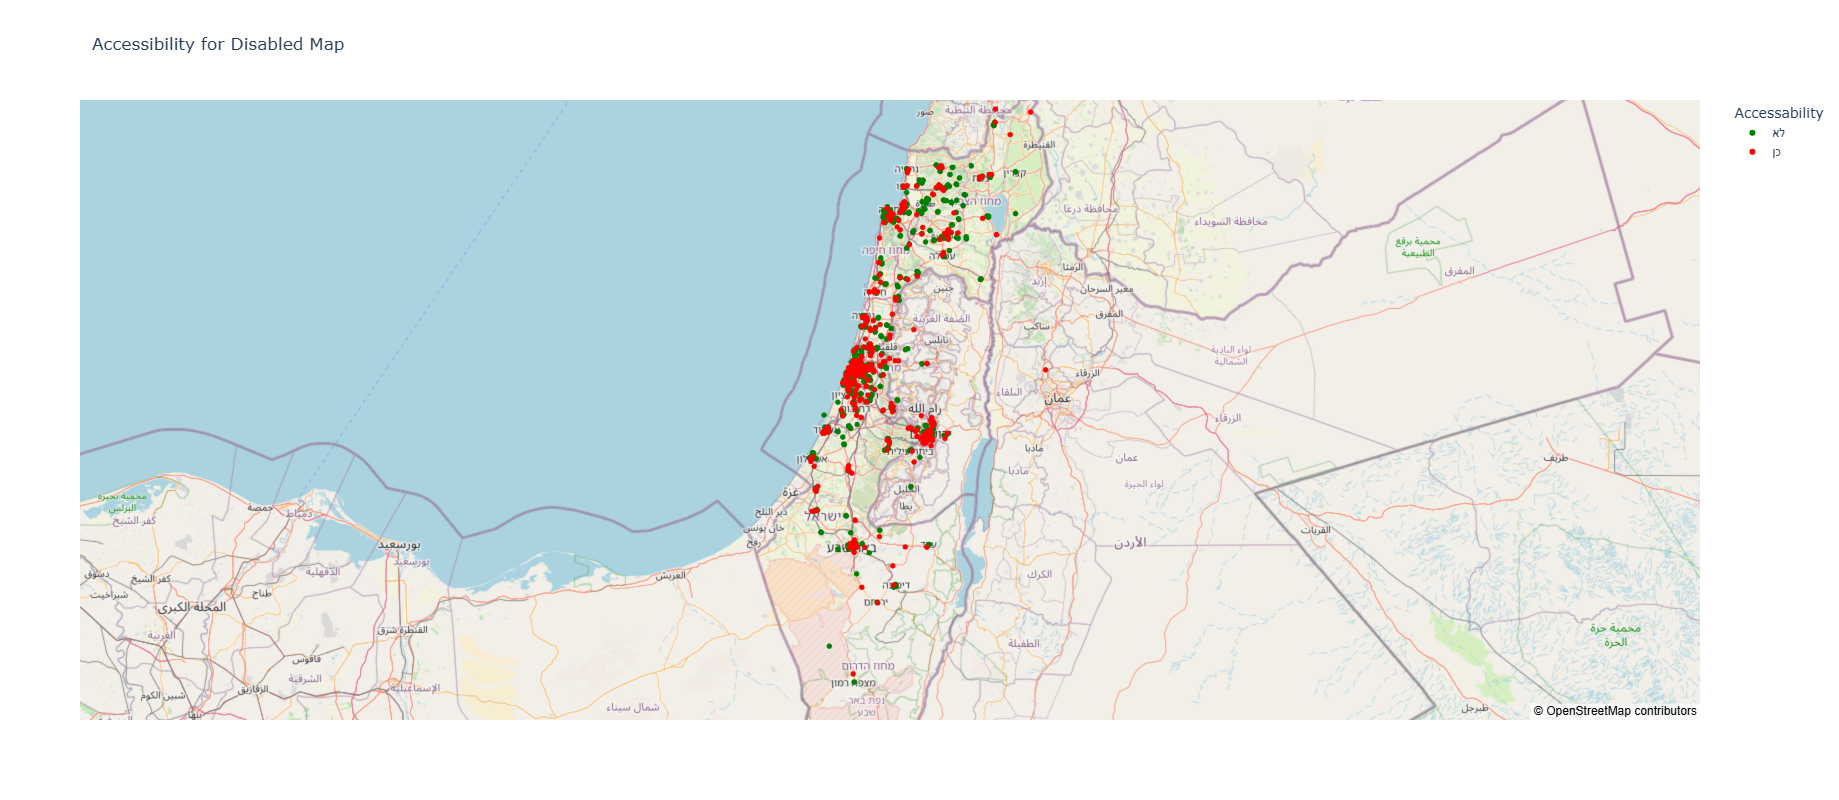

In [39]:

fig = px.scatter_mapbox(data_gmm,lat="X_Coordinate", lon="Y_Coordinate",  color="Need_access",  hover_data=["X_Coordinate", "Y_Coordinate", "Need_access_Type"],  color_discrete_map={"כן": "red", "לא": "green"},  zoom=7,center={"lat": 31.89, "lon": 35},  title="Accessibility for Disabled Map")

fig.update_layout(mapbox_style="open-street-map",width=1200,  height=800,  legend_title=dict(text="Accessability"))

fig.show()

In [40]:
data_gmm[data_gmm['Need_access'] == 'כן'].groupby('Cluster')['Need_access'].count()

Cluster
0     44
1     99
2      2
3     66
4    178
5     44
Name: Need_access, dtype: int64

In [41]:
city_Need_access = data_gmm[data_gmm['Cluster'] == 5].groupby('City')['Need_access'].count().sort_values(ascending=False)
city_Need_access

City
באר שבע                  116
קריית גת                  27
נתיבות                    24
דימונה                    22
ערד                       15
שדרות                     14
אופקים                    10
רהט                        8
ירוחם                      5
קריית ארבע                 4
עומר                       4
מצפה רמון                  3
מיתר                       3
להבים                      3
חצרים                      2
הר הנגב הצפוני מ"א 48      2
כפר עציון                  1
ערערה-בנגב                 1
כסיפה                      1
חורה                       1
תל אביב -יפו               1
תל שבע                     1
Name: Need_access, dtype: int64

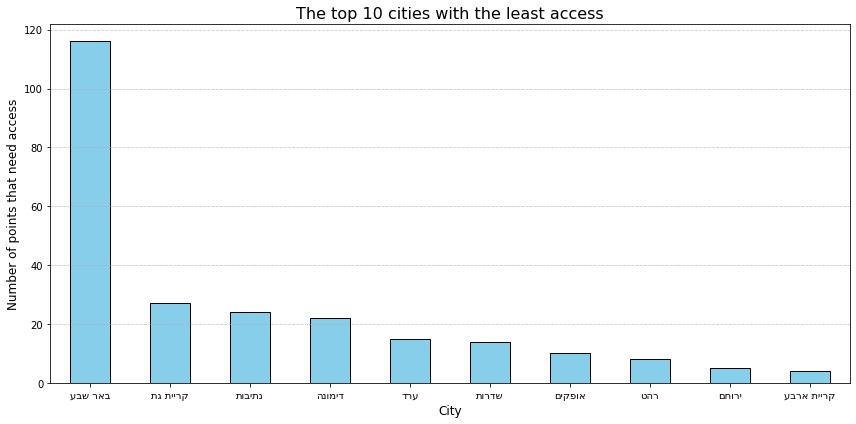

In [42]:
top_10_cities = city_Need_access.head(10)
plt.figure(figsize=(12, 6))
top_10_cities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("The top 10 cities with the least access", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Number of points that need access", fontsize=12)

plt.xticks(ticks=range(len(top_10_cities)), labels=[city[::-1] for city in top_10_cities.index], rotation=0, fontsize=10, rotation_mode='anchor')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### We can see that the city of Tel Aviv needs to address the issue of accessibility for individuals with disabilities.